In [1]:
# Testing whether the projected gradient method works
#  Without the constraints, the problem admits both +x and -x as solutions.
# With the constraints, we should only get +x

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sopt.optimizers.tensorflow import ProjectedGradient
from sopt.optimizers.tensorflow.utils.linesearch import AdaptiveLineSearch

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
x_true = np.ones(20, dtype='float32') * 2

random_mat = np.random.randn(20,20)
A = random_mat @ random_mat / np.max(random_mat)**2

# The output data could be from x=2 or x=-2.
y = np.reshape(A @ x_true**2, [-1])

In [5]:
x_guess = np.random.randn(20).astype('float32') * 10

In [6]:
tf.reset_default_graph()

# x = 0 is also a stationary point. We are trying to avoid that by using clip_value_min > 0
constraint_fn = lambda x: tf.clip_by_value(x, clip_value_min=0.1, clip_value_max=2.1)
var_constr = tf.Variable(x_guess, dtype='float32', constraint=constraint_fn)
var_unconstr = tf.Variable(x_guess, dtype='float32')

y_t = tf.constant(y, dtype='float32')
A_t = tf.constant(A, dtype='float32')                   
                   
x_true_t = tf.constant(x_true, dtype='float32', name='x_true')

def preds_fn(guess_var):
    return tf.reshape(A_t @ guess_var[:,None]**2, [-1])
#def loss_fn(y_pred):
#    return 0.5 * tf.reduce_sum((y_pred - y_t)**2)
def loss_fn(var):
    return 0.5 * tf.reduce_mean((preds_fn(var) - y_t)**2)

loss_constr_t = loss_fn(var_constr)
error_constr_t = tf.reduce_mean((var_constr - x_true_t)**2)

loss_unconstr_t = loss_fn(var_unconstr)
error_unconstr_t = tf.reduce_mean((var_unconstr - x_true_t)**2)

proj_opt = ProjectedGradient(var_constr, loss_fn, name='constr_opt')
proj_min_op = proj_opt.minimize()

unconstr_opt = ProjectedGradient(var_unconstr, loss_fn, name='unconstr_opt')
unconstr_min_op = unconstr_opt.minimize()

#loss_and_update_fn = lambda x, y: loss_fn(x + y), x + y 
#loss_as_t = loss_fn()
#grad

#linesearch = AdaptiveLineSearch()

session = tf.Session()
session.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [7]:
session.run([loss_constr_t, loss_unconstr_t, error_constr_t, error_unconstr_t])

[137369.33, 137369.33, 106.38924, 106.38924]

In [33]:
losses_constr = []
errors_constr = []
losses_unconstr = []
errors_unconstr = []

In [34]:
for i in range(2000):
    session.run([proj_min_op, unconstr_min_op])
    l1, l2, e1, e2, ls1, ls2 = session.run([loss_constr_t, loss_unconstr_t, 
                                            error_constr_t, error_unconstr_t, 
                                            proj_opt._linesearch_iterations, unconstr_opt._linesearch_iterations])
    alpha1, alpha2 = session.run([proj_opt._linesearch._alpha, unconstr_opt._linesearch._alpha])
    losses_constr.append(l1)
    errors_constr.append(e1)
    losses_unconstr.append(l2)
    errors_unconstr.append(e2)
    if i % 50 == 0:
        print(f'{i:8d} constr {l1:10.3g}{e1:10.3g}{ls1:10d}{alpha1:8.3g} unconstr{l2:10.3g}{e2:10.3g}{ls2:10d}{alpha2:8.3g}')

       0 constr       10.6      1.63        217.01e-11 unconstr  7.78e+04        94         17.35e-05
      50 constr      0.546     0.887        88   0.151 unconstr      24.1      15.7        81  0.0188
     100 constr      0.281     0.466       183   0.301 unconstr      2.66       8.8       163  0.0376
     150 constr     0.0989     0.196       279   0.151 unconstr     0.309      6.74       253  0.0753
     200 constr     0.0396    0.0894       367   0.301 unconstr    0.0963      6.26       332  0.0753
     250 constr     0.0149    0.0409       458   0.301 unconstr     0.055       6.1       420  0.0753
     300 constr    0.00551    0.0227       548   0.151 unconstr    0.0423      6.08       508  0.0753
     350 constr    0.00236    0.0164       639  0.0753 unconstr    0.0348       6.1       595   0.151
     400 constr    0.00118    0.0127       721   0.151 unconstr    0.0293      6.14       684  0.0753
     450 constr   0.000671    0.0107       805   0.151 unconstr    0.0245      6.1

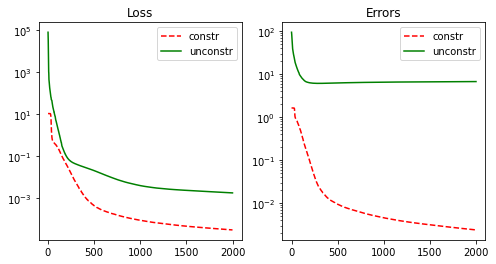

In [35]:

plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(losses_constr, color='red', ls='--', label='constr')
plt.plot(losses_unconstr, color='green', label='unconstr')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(errors_constr, color='red', ls='--', label='constr')
plt.plot(errors_unconstr, color='green', label='unconstr')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Errors')
plt.show()

In [36]:
session.run([var_unconstr, var_constr])

[array([-1.9474392,  1.5239054, -1.7397401,  2.2085707,  2.2883282,
         2.079077 ,  2.13291  ,  2.5188837,  2.1475902,  2.1700957,
        -1.8948554, -1.9078925,  2.196532 , -2.1148746, -2.226457 ,
         2.098402 , -1.8034678,  2.5370429, -1.3051622, -1.557167 ],
       dtype=float32),
 array([2.0219696, 2.0970383, 2.0048847, 2.000141 , 1.9283347, 1.9824817,
        2.0056608, 1.9026554, 1.9376279, 2.0075166, 2.0387979, 2.001208 ,
        1.9914469, 1.9732109, 1.959043 , 1.9905131, 2.0364697, 1.9046984,
        2.061464 , 2.0189376], dtype=float32)]